In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import pickle

In [2]:
data = pd.read_excel('../../../data/tb_stock.xlsx')
df = data[['sc_date', 'sc_coin']]
df.set_index('sc_date', inplace=True)  # Date컬럼을 index로 변환

In [ ]:
# 파라미터 옵션 설정

# 트렌드(추세) 요소(trend): 데이터가 장기적인 측면에서 증가하거나 감소하는 모양새를 의미.
# 순환 요소(cycle): 불규칙적이며 반복적인 장기적인 변화 현상을 의미. 급격한 변화가 없다면 지속되는 특징
# 계절 요소(seasonal): 주, 월, 분기, 반기, 1년 등 특정 주기로 반복되는 특징을 의미
# 불규칙 요소(random/residual): 일정한 규칙성을 인지할 수 없는 변동의 유형. 추세, 순환, 계절성을 뺀 나머지

# 'add(덧셈)'옵션: 추세, 순환, 계절, 불규칙의 합. Trend와 Seasonal이 별개
# 'mul(곱셈)'옵션: 추세, 순환, 계절, 불규칙의 곱. 시간이 지남에 따라(Trend가 상승함에 따라) 변동폭이 증가
# 'Damping'옵션, 시간의 경과에 따라 **추세(trend)**가 점차 감소하거나 완화되는 효과.
#  댐핑된 추세는 시간이 지나면서 추세의 기울기가 감소하여 평평해지는 형태를 취함. 추세 성분에 댐핑 계수를 곱하여 점진적으로 그 영향력을 감소
#  이는 현실적으로 많은 경제, 금융, 그리고 자연 현상에서 장기적으로 무한한 성장이나 감소는 없다고 가정할 때 유용

In [ ]:
# 기간 설정
sort_df = df.loc['2024-04-01' : '2024-06-30']

# 훈련, 테스트 데이터로 나누기
train_size = int(len(sort_df) * 0.7)
train = sort_df['sc_coin'][:train_size]
test = sort_df['sc_coin'][train_size:]

# 파라미터 조합 설정
param_grid = {
    'trend': [None, 'add', 'mul'],                                      # 트렌드(추세) 옵션: 없음, 덧셈적, 곱셈적. 
    'seasonal': [None, 'add', 'mul'],                                   # 계절성 옵션: 없음, 덧셈적, 곱셈적
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # 계절성 주기: 없음, 일 주, 달, 분기, 반기, 년 등..
    'damped_trend': [True, False],                                      # 댐핑된 트렌드 사용 여부
}

# 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE 기준 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [7]:
# 결과 출력
print("학습일:", len(train))
print("예측일:", len(test))
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

학습일: 63
예측일: 28
Best Parameters: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 8, 'trend': 'add'}
Best MSE: 4625475.088910258
Best Metrics: {'MSE': 4625475.088910258, 'MAE': 1832.398339287182, 'MAPE': 0.028142275577040406, 'R²': 0.5892897815314446}


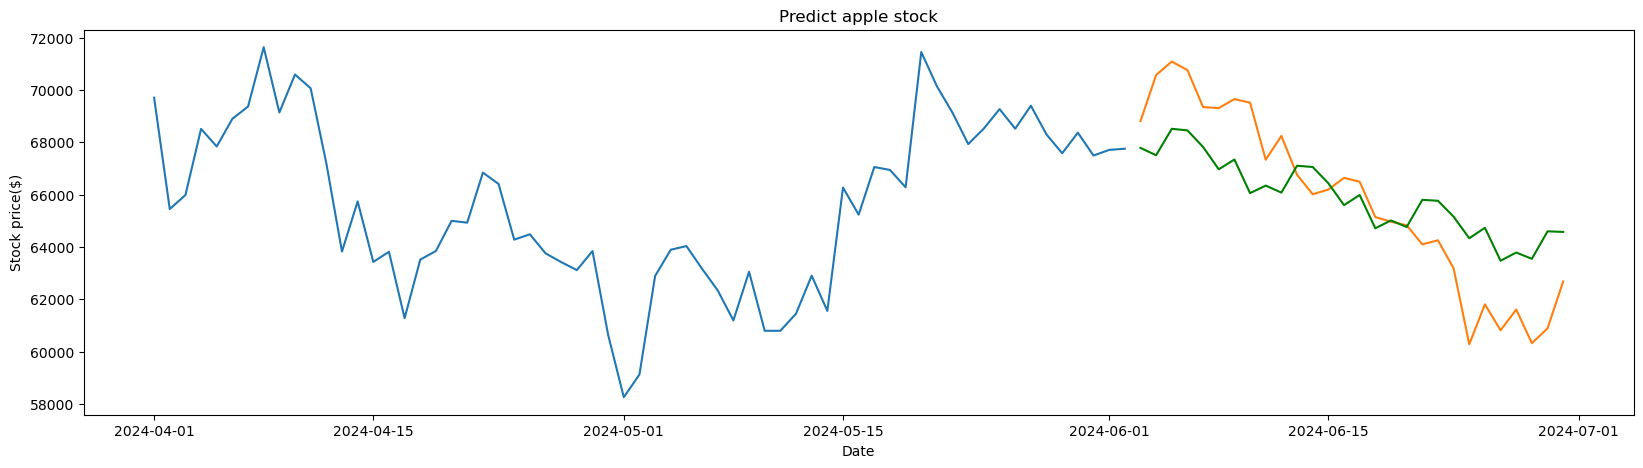

In [8]:
# 최적모델 예측 시각화

# 인덱스 데이터타입을 date로 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict apple stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [10]:
# # 모델 저장
# with open('Regression_Coin_ExponentialSmoothing.pkl', 'wb') as file:
#     pickle.dump(model, file)

# 모델 불러오기
model = pickle.load(open('Regression_Coin_ExponentialSmoothing.pkl', 'rb'))

In [11]:
def predict_stock(stock, date):
    predict_date = datetime.strptime(date, '%Y-%m-%d')
    train_last_date = datetime.strptime(f'{train.index[-1].year}-{train.index[-1].month}-{train.index[-1].day}', '%Y-%m-%d')
    date_sub = predict_date - train_last_date
    predictions = model.forecast(date_sub.days)
    return f'{stock} {date}: {predictions[-1]}'

predict_stock('coin', '2024-08-28')

C:\Users\4\AppData\Local\Temp\ipykernel_2516\4090526690.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f'{stock} {date}: {predictions[-1]}'


'coin 2024-08-28: 65455.67621561532'